In [1]:
# results directories:
# /home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan/anli
# /home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan/math

%load_ext autoreload
%autoreload 2

In [2]:
import analyze_utils

In [3]:
dir_single_query = '/home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan_2/math'
r = analyze_utils.load_results_and_cache_json(dir_single_query, save_file='r.pkl')

r['use_single_query'] = r['single_query']
r['final_answer_pos_initial_token']
r = analyze_utils.postprocess_results(r)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 320.50it/s]


In [4]:
r[(~r['single_query'].astype(bool)) & (r['do_reranking'].astype(bool))][['checkpoint', 'task_name']].value_counts()

checkpoint               task_name    
gpt2-xl                  subtract_two     256
                         multiply_two     256
                         max_two          256
                         first_two        256
                         divide_two       256
                         add_two          256
EleutherAI/gpt-j-6B      divide_two       128
gpt2-xl                  square_one       128
                         fibonacci_one    128
                         exp_one          128
                         double_one       128
EleutherAI/gpt-neo-2.7B  subtract_two     128
                         square_one       128
                         multiply_two     128
                         max_two          128
EleutherAI/gpt-j-6B      add_two          128
EleutherAI/gpt-neo-2.7B  fibonacci_one    128
                         exp_one          128
                         double_one       128
                         divide_two       128
                         add_two         

In [5]:
r['use_single_query'].value_counts()

NameError: name 'rt' is not defined

In [6]:
r['do_reranking'].value_counts()

0    15360
1     8448
Name: do_reranking, dtype: int64

In [9]:
for model in r['checkpoint'].unique():
    print(model)
    rt_model = r[(r['checkpoint'] == model) & (r['single_query'].astype(bool))]
    table = (rt_model
        # mean over templates, task_name)
        .groupby(['checkpoint', 'n_shots', 'do_reranking', 'single_query', 'task_name'])[[f'Recall @ {3} suffixes']]
        .mean()
        .reset_index()
    )
    print(table.head())
    print(len(table), '\n'*3)


EleutherAI/gpt-neo-2.7B
                checkpoint  n_shots  do_reranking  single_query  \
0  EleutherAI/gpt-neo-2.7B        1             0             1   
1  EleutherAI/gpt-neo-2.7B        1             0             1   
2  EleutherAI/gpt-neo-2.7B        1             0             1   
3  EleutherAI/gpt-neo-2.7B        1             0             1   
4  EleutherAI/gpt-neo-2.7B        1             0             1   

       task_name  Recall @ 3 suffixes  
0        add_two                  1.0  
1     divide_two                  1.0  
2     double_one                  0.0  
3        exp_one                  0.0  
4  fibonacci_one                  0.0  
30 



gpt2-xl
  checkpoint  n_shots  do_reranking  single_query      task_name  \
0    gpt2-xl        1             0             1        add_two   
1    gpt2-xl        1             0             1     divide_two   
2    gpt2-xl        1             0             1     double_one   
3    gpt2-xl        1             0           

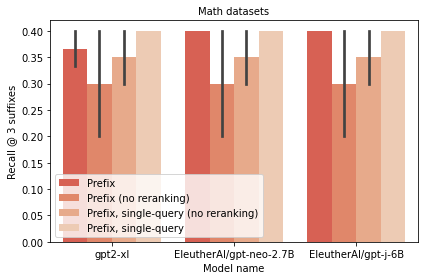

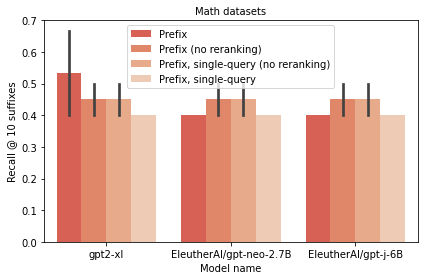

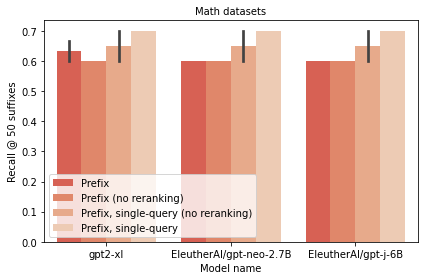

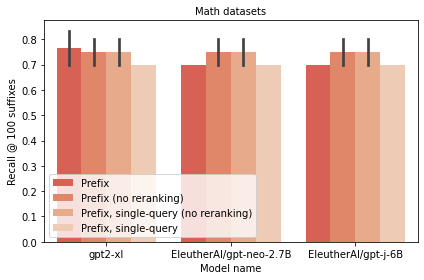

In [16]:
from typing import Dict

# rt = r[r.task_name.isin(['add_two', 'multiply_two', 'subtract_two'])]
import matplotlib.pyplot as plt
rt = r

def make_legend__prefix(table_row: Dict) -> str:
    single_query_str = {
        0: '',
        1: ', single-query'
    }[table_row['single_query']]
    rerank_str = {
        0: ' (no reranking)',
        1: ''
    }[table_row['do_reranking']]
    
    return 'Prefix' + single_query_str + rerank_str

for metric_key in [#'final_answer_pos_initial_token',
                   f'Recall @ {3} suffixes',
                   f'Recall @ {10} suffixes', 
                   f'Recall @ {50} suffixes', 
                   f'Recall @ {100} suffixes', 
                   ]:
    table = (rt
        # mean over templates, task_name)
        .groupby(['checkpoint', 'n_shots', 'do_reranking', 'single_query'])[[metric_key]]
        .mean()
        .reset_index()
    ).fillna(10_000)
    table['legend'] = table.apply(make_legend__prefix, axis=1)
    analyze_utils.plot_tab(table, metric_key=metric_key, title='Math datasets', add_legend=False)

    # if metric_key == 'final_answer_pos_initial_token':
      # plt.savefig('../results/prompt_gen/math_barplot.pdf', bbox_inches='tight')
    plt.show()


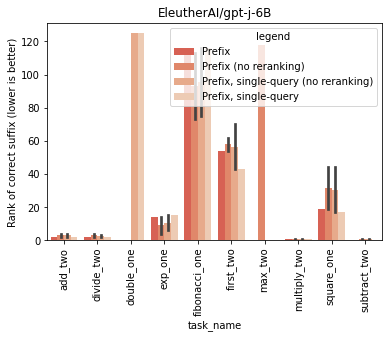

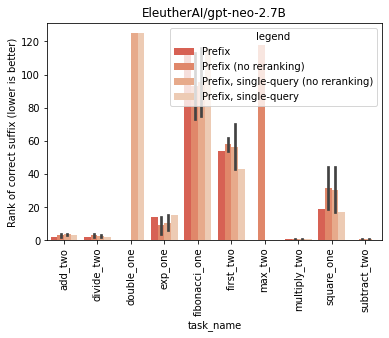

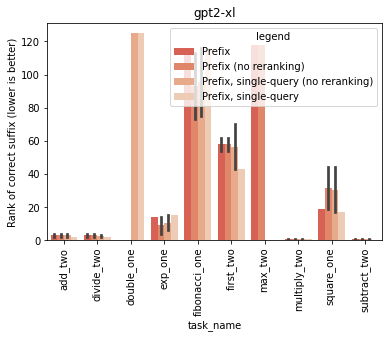

In [17]:
# cols_to_view = r_single_query.columns # cols_to_view
import pandas as pd
import seaborn as sns

key_vars = ['checkpoint', 'n_shots', 'single_query', 'do_reranking', 'task_name']
cols_to_view = [col for col in r.columns if col.startswith('final')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    rg = r.groupby(key_vars)[cols_to_view].mean().round(2)
    # display(rg[rg['final_answer_found'] < 1.0])
    # display(rg)
# r.groupby(['template_num_init_string', 'use_single_query']).median().round(2)['final_model_queries'] # look at templates

for checkpoint in rg.reset_index().checkpoint.unique():
    rp = rg.reset_index()
    # checkpoint = 'EleutherAI/gpt-j-6B'
    metric_key = 'final_answer_pos_initial_token'

    rp = rp[rp['checkpoint'] == checkpoint]
    rp['legend'] = rp.apply(make_legend__prefix, axis=1)
    hue_order = analyze_utils.get_hue_order(rp['legend'])
    plt.title(checkpoint)
    sns.barplot(x='task_name', y=metric_key, hue_order=hue_order,
                hue='legend', data=rp, palette=analyze_utils.COLORS)  # data=tab[tab['n_shots'] == 1])
    plt.xticks(rotation='vertical')
    plt.ylabel(analyze_utils.YLABS.get(metric_key, metric_key))
    plt.show()